<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/NLP/Embeddings/Fairy_tales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import gensim
import numpy as np
import os
import seaborn as sns
import zipfile

from IPython.display import clear_output
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

In [58]:
%matplotlib inline

###Download vocabularies and vector representation

In [6]:
def download_vec(name):
  path = os.path.dirname(name)
  with zipfile.ZipFile(name, 'r') as zf:
    zf.extractall(path)
  os.remove(name)

In [ ]:
!wget -O ukrainian.zip "https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/9CAeNsJiInoyUA"
!wget -O russian.zip "https://getfile.dokpub.com/yandex/get/https://yadi.sk/d/3yG0-M4M8fypeQ"
clear_output()

for name in ['ukrainian.zip', 'russian.zip']:
  download_vec(name)

In [19]:
!wget ukr_rus.train.txt https://raw.githubusercontent.com/yandexdataschool/nlp_course/2022/week01_embeddings/ukr_rus.train.txt
!wget ukr_rus.test.txt https://raw.githubusercontent.com/yandexdataschool/nlp_course/2022/week01_embeddings/ukr_rus.test.txt
clear_output()

### Load embeddings

In [21]:
uavec = 'cc.uk.300.vec'
ruvec = 'cc.ru.300.vec'

In [10]:
ua_emb = KeyedVectors.load_word2vec_format(uavec)
ru_emb = KeyedVectors.load_word2vec_format(ruvec)

### Check for two most contradictive words from both languages

In [13]:
ua_emb.most_similar(ua_emb[['паляниця']], topn=10)

[('паляниця', 1.0),
 ('хлібина', 0.6972880959510803),
 ('паляницю', 0.6888859272003174),
 ('паляниці', 0.6719595789909363),
 ('Паляниця', 0.6607965230941772),
 ('пашниця', 0.6127423644065857),
 ('ґаздиня', 0.6104057431221008),
 ('сосонка', 0.6035154461860657),
 ('здоба', 0.6022063493728638),
 ('мисочка', 0.6010351181030273)]

In [15]:
ru_emb.most_similar(ru_emb[['Сыктывкар']], topn=10)

[('Сыктывкар', 1.0000001192092896),
 ('Ухта', 0.7353183031082153),
 ('Усинск', 0.7093490958213806),
 ('Сосногорск', 0.6975598931312561),
 ('Петрозаводск', 0.6828557252883911),
 ('Воркута', 0.6743683815002441),
 ('Сургут', 0.6718339323997498),
 ('Сыктывкара', 0.6710988879203796),
 ('Нижневартовск', 0.6590413451194763),
 ('Йошкар-Ола', 0.6539392471313477)]

"Сыктывкар" is so brutal it's cosine similarity with itself is more than 1.

Thing is there is a lowercase "сыктывкар" with cos.similarity of 0.9999998807.. and if we sum them up and divide by 2 we'll get 1.

### Sample some small vocab pairs

In [23]:
def load_word_pairs(filename, ua_emb=ua_emb, ru_emb=ru_emb):
    uk_ru_pairs = []
    uk_vectors = []
    ru_vectors = []
    with open(filename, "r") as vocab:
        for line in vocab:
            ua, ru = line.rstrip().split("\t")
            if ua not in ua_emb or ru not in ru_emb:
                continue
            uk_ru_pairs.append((ua, ru))
            uk_vectors.append(ua_emb[ua])
            ru_vectors.append(ru_emb[ru])
    return uk_ru_pairs, np.array(uk_vectors), np.array(ru_vectors)

In [25]:
ua_ru_train, X_train, y_train = load_word_pairs("ukr_rus.train.txt")
ua_ru_test, X_test, y_test = load_word_pairs("ukr_rus.test.txt")

### Try linear regression

In [102]:
#print(best_model) #Ridge(alpha=0.001, max_iter=100)

Ridge(alpha=0.001, max_iter=100)


In [117]:
linear = LinearRegression()
linear.fit(X_train, y_train)

LinearRegression()

In [105]:
y_pred = linear.predict(X_test)
mae = mean_absolute_error(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)

Well, since vectors' values are so small, these numbers don't actually provide us a detailed insight into the nature of the mistakes

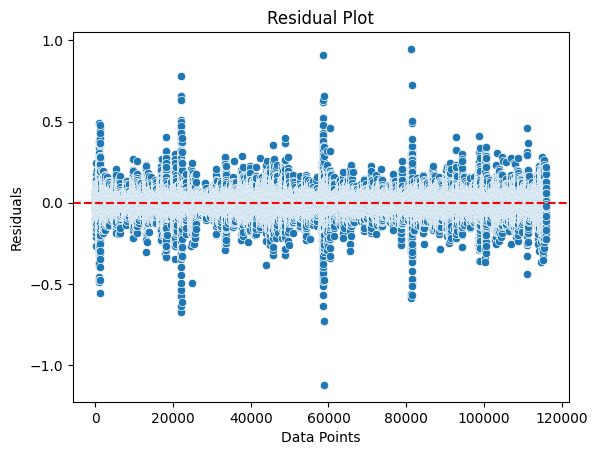

In [106]:
residuals = y_pred - y_test
residuals = residuals.flatten()
sns.scatterplot(x=np.arange(len(residuals)), y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Data Points')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## Measure top-1, 5, 10 nearest neighbors in pairs  

In [107]:
august = linear.predict(ua_emb["серпень"].reshape(1, -1))
ru_emb.most_similar(august)

[('апрель', 0.8542020916938782),
 ('июнь', 0.8412148952484131),
 ('март', 0.8397750854492188),
 ('сентябрь', 0.8359695076942444),
 ('февраль', 0.8329088091850281),
 ('октябрь', 0.8312200903892517),
 ('ноябрь', 0.8278502821922302),
 ('июль', 0.8236492872238159),
 ('август', 0.8120948672294617),
 ('декабрь', 0.8038350343704224)]

In [108]:
def precision(pairs: list, mapped_vectors: np.ndarray, topn=1)-> float:
    """
    :args:
        pairs = list of right word pairs [(uk_word_0, ru_word_0), ...]
        mapped_vectors: np.ndarray = list of embeddings after mapping from source embedding space to destination embedding space
        topn = the number of nearest neighbours in destination embedding space to choose from
    :returns:
        precision_val, float number, total number of words for those we can find right translation at top K.
    """
    # Check if number of pairs was equal to dims of mapped_vector
    assert len(pairs) == len(mapped_vectors)
    num_matches = 0
    # For idx, ua, rus in pairs
    for i, (ua, ru) in enumerate(pairs):
      # Get predicted by linear model vector representation of the word
      ua_vec = mapped_vectors[i]
      # Find top N vectors similar to ours
      similars = ru_emb.similar_by_vector(ua_vec, topn=topn)
      if ru in [word for word, vec in similars]:
        # If our russian word from pair is in those top N we score a point
        num_matches+=1
    precision_val = num_matches / len(pairs)
    return precision_val

### Bathe in tests

In [95]:
assert precision([("серпень", "август")], august, topn=5) == 0.0
assert precision([("серпень", "август")], august, topn=9) == 1.0
assert precision([("серпень", "август")], august, topn=10) == 1.0
assert precision(ua_ru_test, X_test) == 0.0
assert precision(ua_ru_test, y_test) == 1.0

In [114]:
precision_top1 = precision(ua_ru_test, linear.predict(X_test), 1)
precision_top5 = precision(ua_ru_test, linear.predict(X_test), 5)

assert precision_top1 >= 0.6356
assert precision_top5 >= 0.8113
#pretty sure original value of 0.813 was a mistake since no way in current state the model can do better than 0.8113

In [123]:
print(f"Top5: {round(100*precision_top5,1)}%\nTop1: {round(100*precision_top1, 1)}%")

Top5: 81.1%
Top1: 63.6%


Seems like linear regression does a pretty good job showing that similar in meaning ua to ru word is in top 5 in 81% of pairs in dictionary. And in 63% word to word top1 mapping is correct.

Btw for top9 the result is slighlty(no surprise) better than top5 - ~85%